In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
from torchvision import transforms
from torchvision.datasets import MNIST
os.chdir("/nfs/students/winter-term-2020/project-4/schwienb/project-4")

In [2]:
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.models.pixelcnn import PixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images, draw_likelihood_plot, positionalencoding2d, randomize_background_normal
from src.utils.ood_test import plot_roc_auc, test_ood, test_ood_coco
import torch.nn.functional as F
from src.models.coco_pixelcnn import COCOPixelCNN
from src.data.coco import COCODataModule

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [4]:
experiment_name = 'PixelCNN_BgAug_D32_G_COCO_1'

In [5]:
exp = Experiment(experiment_name)

In [6]:
# exp._setup()
exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Pixel Likelihood

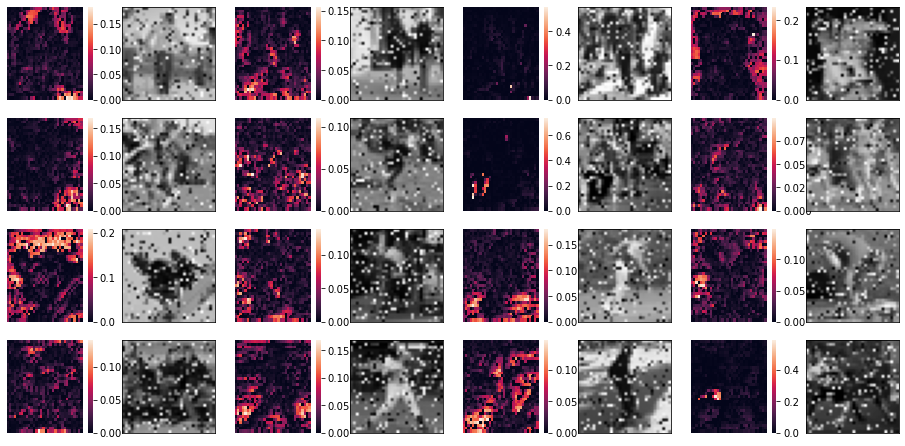

In [6]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp.model, cmap="rocket", vmax=None, img_index=0)

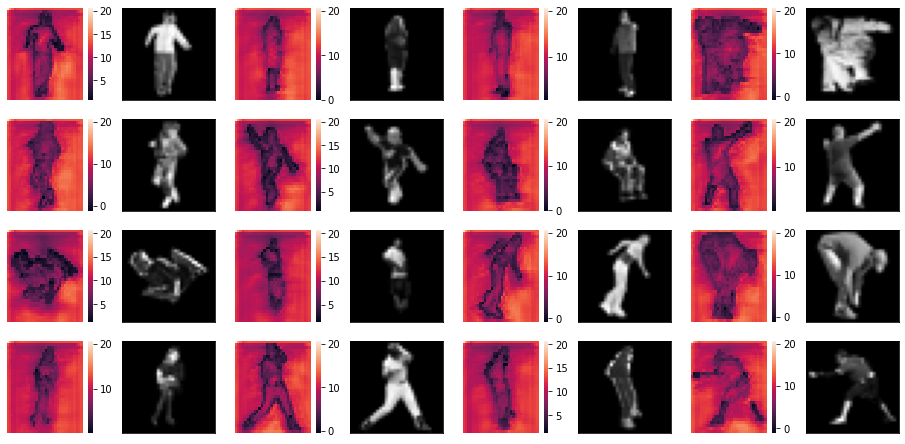

In [10]:
draw_likelihood_plot(exp.dataset.test_dataloader(), exp.model, cmap="rocket", vmax=None, img_index=1)

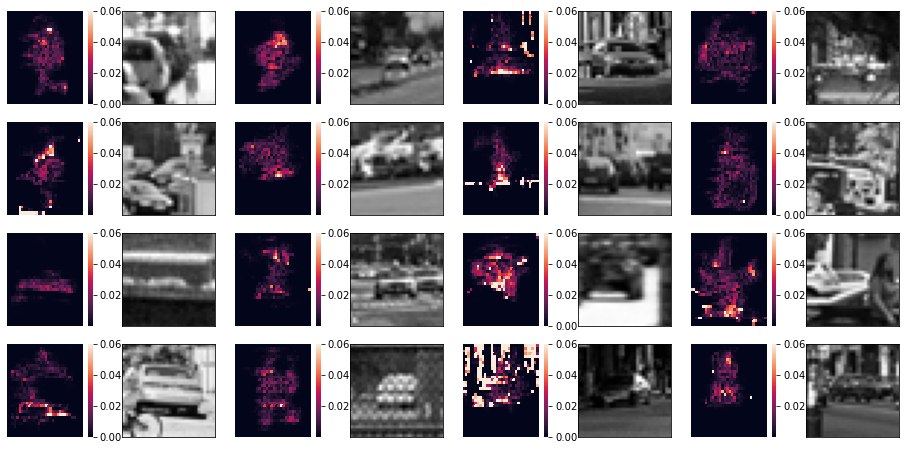

In [30]:
dataset_params = {
    'foreground_data_dir': '/nfs/students/winter-term-2020/project-4/yurtkulus/project-4/data/COCO/foreground_images/car', 
    'background_data_dir': '/nfs/students/winter-term-2020/project-4/yurtkulus/project-4/data/COCO/background_images/car', 
    'batch_size': 64,
    'convert_grayscale': True,
    'resize': True,
    'background_only': False,
    'rand_bg': True
}
car = COCODataModule(**dataset_params)
car.prepare_data()
car.setup()

car_test = car.test_dataloader()
draw_likelihood_plot(car_test, exp.model, cmap="rocket", vmax=0.06, img_index=0)

In [18]:
targets, results = test_ood_coco(exp, exp.dataset.test_dataloader(), car_test)

Set SLURM handle signals.


Set SLURM handle signals.


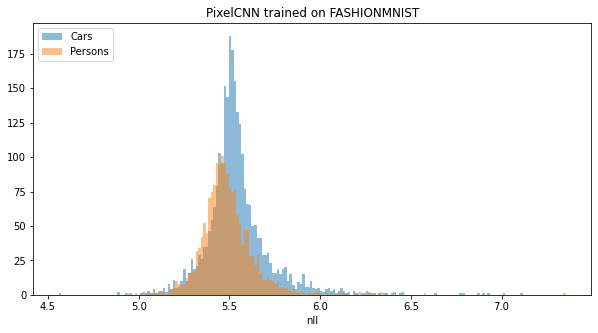

In [19]:
idd_losses = results[0:1751]
ood_losses = results[1751:]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(ood_losses, bins, alpha=0.5, label='Cars')
plt.hist(idd_losses, bins, alpha=0.5, label='Persons')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on FASHIONMNIST')
plt.show()

## Generated images

/nfs/students/winter-term-2020/project-4/schwienb/project-4/src/utils/pixelcnn.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


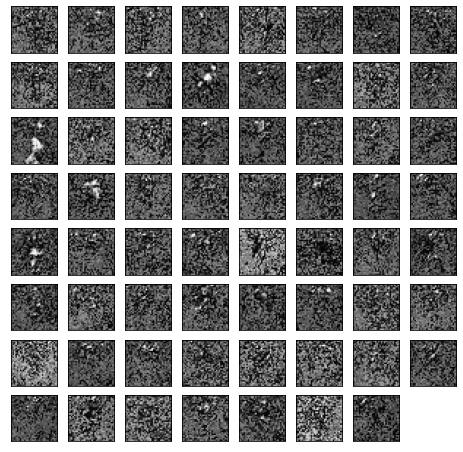

In [20]:
generate_images(exp.model, channels=1, img_dim=(32,32))

In [8]:
# exp.dataset.batch_size = 1
test = exp.dataset.test_dataloader()



In [9]:
j = 0
for i in iter(test):
    j += 1
    if j == 4:
        img = i 

In [10]:
img[0][0].shape

torch.Size([1, 1, 32, 32])

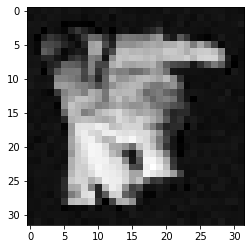

In [21]:
plt.imshow(randomize_background_normal(img[1][0][0][0].cuda(), mean=0.06, std=0.01).cpu(), cmap="gray")

In [14]:
randomize_background_normal(img[1][0][0][0].cuda(), mean=0.02, std=0.01)

tensor([[0.0221, 0.0328, 0.0108,  ..., 0.0242, 0.0213, 0.0253],
        [0.0278, 0.0460, 0.0013,  ..., 0.0211, 0.0217, 0.0300],
        [0.0201, 0.0102, 0.0065,  ..., 0.0306, 0.0275, 0.0248],
        ...,
        [0.0269, 0.0107, 0.0000,  ..., 0.0173, 0.0174, 0.0206],
        [0.0313, 0.0218, 0.0115,  ..., 0.0144, 0.0138, 0.0000],
        [0.0041, 0.0175, 0.0053,  ..., 0.0134, 0.0148, 0.0382]],
       device='cuda:0')

In [15]:
img[0][0][0][0]

tensor([[0.0275, 0.0275, 0.0235,  ..., 0.0941, 0.1020, 0.1020],
        [0.0275, 0.0275, 0.0157,  ..., 0.0941, 0.1020, 0.1020],
        [0.0275, 0.0275, 0.0196,  ..., 0.0941, 0.0980, 0.1020],
        ...,
        [0.0667, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0784],
        [0.0745, 0.0980, 0.0941,  ..., 0.0863, 0.0824, 0.0784],
        [0.0824, 0.1098, 0.1451,  ..., 0.0902, 0.0824, 0.0784]])

In [80]:
# encode = torch.Tensor(255,32,32).fill_(0)

In [81]:
one_hot = torch.FloatTensor(labels.size(0), 256, labels.size(2), labels.size(3)).zero_()


In [82]:
target = one_hot.scatter_(1, labels.data, 1)

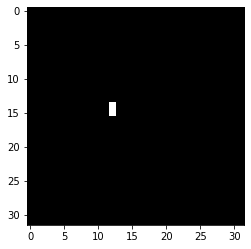

In [85]:
plt.imshow(target[0,178], cmap="gray")

In [86]:
target.shape

torch.Size([1, 256, 32, 32])

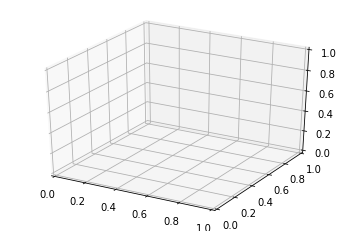

In [98]:
fig = plt.figure()
ax = plt.axes(projection="3d")
def z_function(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)

In [116]:
X = target[0,0]
Y = target[0,1]
Z = target[0,10]

In [142]:
a = torch.Tensor([1,1])

In [146]:
a.unsqueeze(1).shape()

TypeError: 'torch.Size' object is not callable